In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


tf.__version__

2023-04-18 15:37:48.572125: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 15:37:48.770957: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-18 15:37:49.492162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-18 15:37:49.492213: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,484.4822,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,774.6917,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,644.6140,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,630.3364,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,392.8587,358.78


In [3]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,484.4822
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,774.6917
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,644.6140
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,630.3364
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,392.8587


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

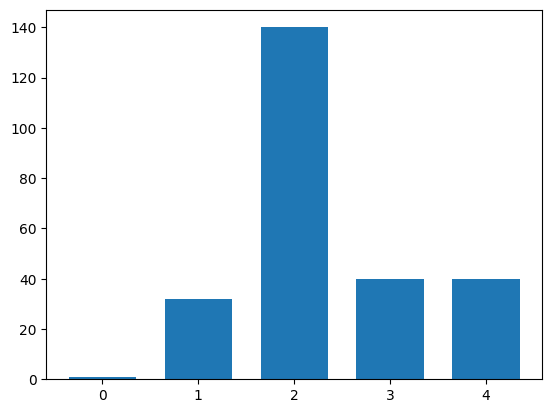

In [4]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [5]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.0000,0.0000,0.0000,1.0000,4.0000
Pos2,253.0,0.774704,1.388956,0.0000,0.0000,0.0000,1.0000,4.0000
Pos3,253.0,0.632411,1.258013,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,253.0,0.557312,1.218930,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,253.0,0.513834,1.121934,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,253.0,0.430830,1.054167,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,253.0,0.383399,1.007532,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,253.0,0.533597,1.163200,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,253.0,0.332016,0.904378,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,253.0,0.284585,0.867193,0.0000,0.0000,0.0000,0.0000,4.0000


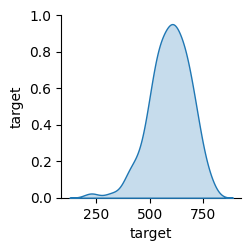

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set
sns.pairplot(dataframe[['target']], diag_kind='kde')


In [6]:
# remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose()

# remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose())

        count        mean        std       min      25%       50%       75%  \
Pos1    249.0    0.646586   1.239308    0.0000    0.000    0.0000    1.0000   
Pos2    249.0    0.738956   1.353061    0.0000    0.000    0.0000    1.0000   
Pos3    249.0    0.614458   1.239452    0.0000    0.000    0.0000    0.0000   
Pos4    249.0    0.534137   1.187909    0.0000    0.000    0.0000    0.0000   
Pos5    249.0    0.510040   1.118439    0.0000    0.000    0.0000    0.0000   
Pos6    249.0    0.437751   1.061202    0.0000    0.000    0.0000    0.0000   
Pos7    249.0    0.389558   1.014438    0.0000    0.000    0.0000    0.0000   
Pos8    249.0    0.542169   1.170551    0.0000    0.000    0.0000    0.0000   
Pos9    249.0    0.337349   0.910651    0.0000    0.000    0.0000    0.0000   
Pos10   249.0    0.289157   0.873399    0.0000    0.000    0.0000    0.0000   
Pos11   249.0    0.212851   0.739766    0.0000    0.000    0.0000    0.0000   
Pos12   249.0    0.248996   0.834156    0.0000    0.

In [7]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,249.0,6.465863e-01,1.239308,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,249.0,7.389558e-01,1.353061,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,249.0,6.144578e-01,1.239452,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,249.0,5.341365e-01,1.187909,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,249.0,5.100402e-01,1.118439,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,249.0,4.377510e-01,1.061202,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,249.0,3.895582e-01,1.014438,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,249.0,5.421687e-01,1.170551,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,249.0,3.373494e-01,0.910651,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,249.0,2.891566e-01,0.873399,0.000000,0.000000,0.000000,0.000000,4.000000


In [42]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
n_pos = 16
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(249, 80)
(249,)
(249, 81)


In [43]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#x_data = data[:,0:n_features]
#y_data = data[:,n_features]
data = shuffle(data, random_state=39)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(len(x_train), 'training examples')
print(len(x_test), 'test and validation examples')
print(x_train.shape)
print(y_train.shape)

199 training examples
50 test and validation examples
(199, 80)
(199,)


In [78]:
""" # Linear model
input = tf.keras.Input( shape=(n_features,) , name="ohe_input")
output = tf.keras.layers.Dense(1)(input)

model = tf.keras.Model(inputs=input,outputs=output,name="linear_model")
model.summary() 
learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error')"""

# Sum of two MLP models

""" n_features_red = int(n_features/2)

input_MLP1 = tf.keras.Input( shape=(n_features_red,) )
x = tf.keras.layers.Dense(16,activation='relu')(input_MLP1)
output_MLP1 = tf.keras.layers.Dense(1)(x)
model_MLP1 = tf.keras.Model(inputs=input_MLP1,outputs=output_MLP1)

input_MLP2 = tf.keras.Input( shape=(n_features_red,) )
x = tf.keras.layers.Dense(16,activation='relu')(input_MLP2)
output_MLP2 = tf.keras.layers.Dense(1)(x)
model_MLP2 = tf.keras.Model(inputs=input_MLP2,outputs=output_MLP2)

input_global = tf.keras.Input( shape=(n_features,))
input1,input2 = tf.split(input_global, [n_features_red,n_features_red])
output1 = model_MLP1(input1)
output2 = model_MLP2(input2)
output_global = output1 + output2
model = tf.keras.Model(inputs=input_global, outputs=output_global)

learning_rate = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='mean_absolute_error')   """

n_features_red = int(n_features/2)
input1 = tf.keras.Input( shape=(n_features_red,), name='input1' )
input2 = tf.keras.Input( shape=(n_features_red,), name='input2' )

#x = tf.keras.layers.Dense(16,activation='relu')(input1)
x = tf.keras.layers.Dense(8,activation='relu')(input1)
output1 = tf.keras.layers.Dense(1)(x)

x = tf.keras.layers.Dense(16,activation='relu')(input2)
x = tf.keras.layers.Dense(8,activation='relu')(input2)
output2 = tf.keras.layers.Dense(1)(x)

x = tf.keras.layers.concatenate([output1,output2])
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=[input1,input2],outputs=output)
model.summary()
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

learning_rate = 0.01
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')



Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 40)]         0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 40)]         0           []                               
                                                                                                  
 dense_50 (Dense)               (None, 8)            328         ['input1[0][0]']                 
                                                                                                  
 dense_53 (Dense)               (None, 8)            328         ['input2[0][0]']                 
                                                                                            

In [79]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

epochs = 200
batch_size = 4

#history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
x_train1 = np.zeros((n_data,40))
x_train2 = np.zeros((n_data,40))
#x_train1[:,0:40] = x_train[:,0:40]
#x_train2[:,0:40] = x_train[:,40:80]
history = model.fit(x=[x_train[:,0:40],x_train[:,40:80]], y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)
#history = model.fit([x_train1,x_train2], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/200
45/45 - 1s - loss: 0.8385 - val_loss: 0.6416 - lr: 0.0100 - 517ms/epoch - 11ms/step
Epoch 2/200
45/45 - 0s - loss: 0.6849 - val_loss: 0.3932 - lr: 0.0100 - 42ms/epoch - 938us/step
Epoch 3/200
45/45 - 0s - loss: 0.5211 - val_loss: 0.2644 - lr: 0.0100 - 41ms/epoch - 914us/step
Epoch 4/200
45/45 - 0s - loss: 0.4128 - val_loss: 0.2973 - lr: 0.0100 - 41ms/epoch - 901us/step
Epoch 5/200
45/45 - 0s - loss: 0.3392 - val_loss: 0.3439 - lr: 0.0100 - 40ms/epoch - 893us/step
Epoch 6/200
45/45 - 0s - loss: 0.3207 - val_loss: 0.2857 - lr: 0.0100 - 46ms/epoch - 1ms/step
Epoch 7/200
45/45 - 0s - loss: 0.2923 - val_loss: 0.3685 - lr: 0.0100 - 48ms/epoch - 1ms/step
Epoch 8/200
45/45 - 0s - loss: 0.3497 - val_loss: 0.3333 - lr: 0.0100 - 41ms/epoch - 912us/step
Epoch 9/200
45/45 - 0s - loss: 0.2887 - val_loss: 0.3121 - lr: 0.0100 - 41ms/epoch - 920us/step
Epoch 10/200
45/45 - 0s - loss: 0.2782 - val_loss: 0.3465 - lr: 0.0100 - 49ms/epoch - 1ms/step
Epoch 11/200
45/45 - 0s - loss: 0.2750 - val_

Best epoch: 3


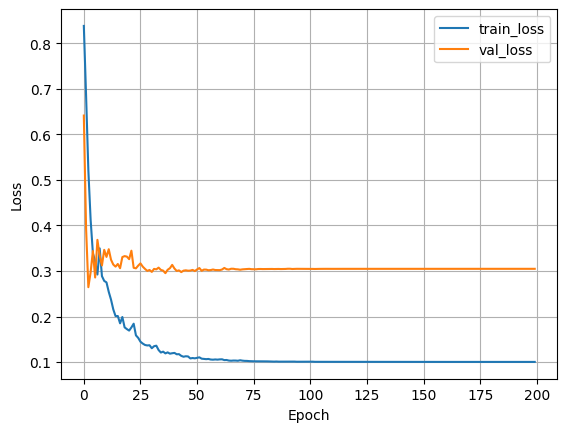

In [80]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

best_model = tuner.hypermodel.build(best_hps)

# Retrain the model
best_model.fit(x_train, y_train, epochs=best_epoch, batch_size=batch_size, validation_split=0.1,callbacks=[reduce_lr], verbose=2) """

In [81]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 2ms/step
(50, 1)
(50, 1)


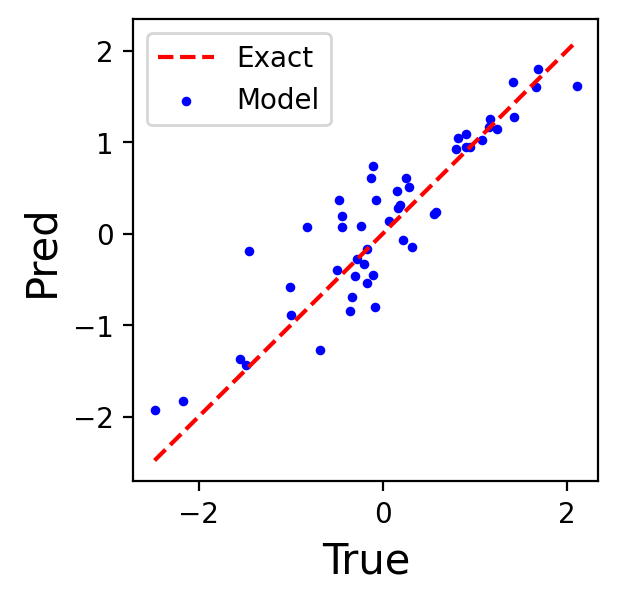

Test MAE: 0.31951200055732665


In [82]:
# Pred vs True values on test set 

#y_pred = model.predict(test_features)
#y_pred = model.predict(x_test)
y_pred = model.predict([x_test[:,0:40],x_test[:,40:80]])
y_pred.shape
y_true = np.zeros((len(y_test),1))
y_true[:,0] = y_test[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

7/7 [==============================] - 0s 771us/step
(199, 1)
(199, 1)


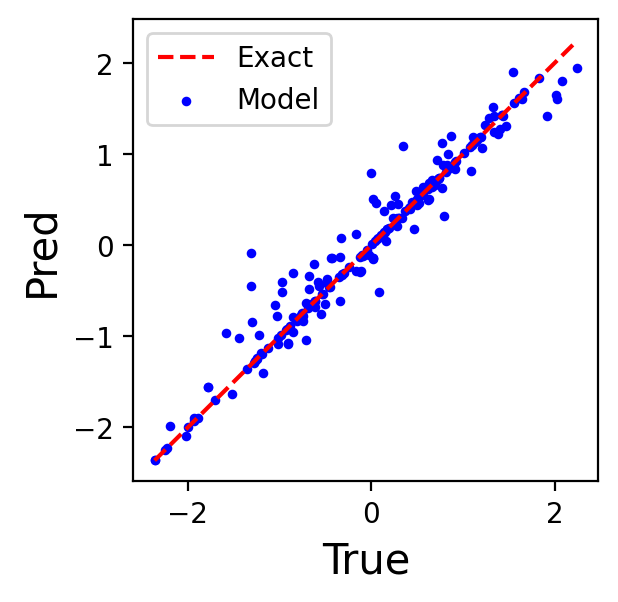

Train MAE: 0.12080895768243462


In [83]:
# Pred vs True values on training set 

#y_pred = model.predict(x_train)
y_pred = model.predict([x_train[:,0:40],x_train[:,40:80]])
y_pred.shape
y_true = np.zeros((len(y_train),1))
y_true[:,0] = y_train[:]

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae))

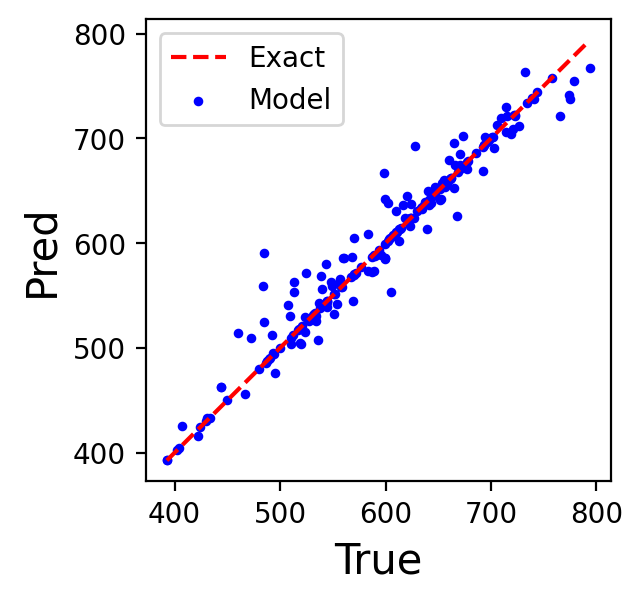

Train MAE (non-normalized): 10.510838260639137


In [84]:
# Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae))

In [139]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

7/7 [==============================] - 0s 699us/step


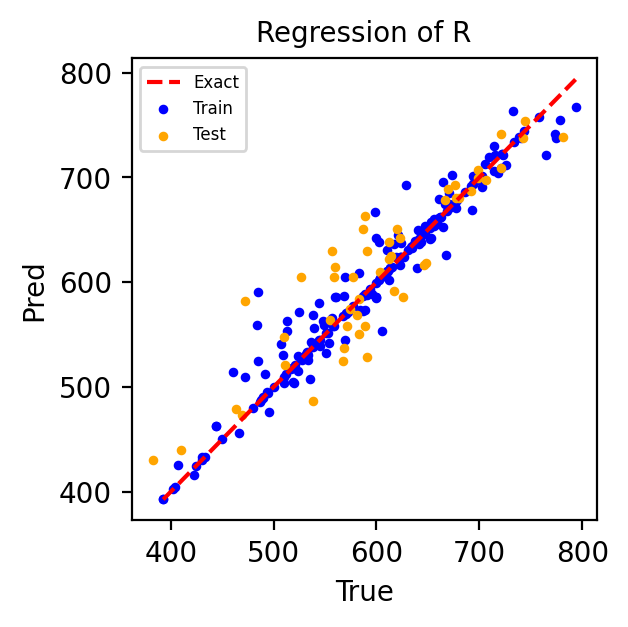

train MAE (non-normalized): 10.510838260639137
test MAE (non-normalized): 27.79876615625001


In [85]:
# Evaluate the model with non-normalized units on the whole dataset

#y_pred_test = model.predict(x_test)
y_pred_test = model.predict([x_test[:,0:40],x_test[:,40:80]])
y_true_test = np.zeros((len(y_test),1))
y_true_test[:,0] = y_test[:]

#y_pred_train = model.predict(x_train)
y_pred_train = model.predict([x_train[:,0:40],x_train[:,40:80]])
y_true_train = np.zeros((len(y_train),1))
y_true_train[:,0] = y_train[:]

#y_pred_val = model.predict(val_ds)
#y_true_val = np.zeros((len(val['target']),1))
#y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

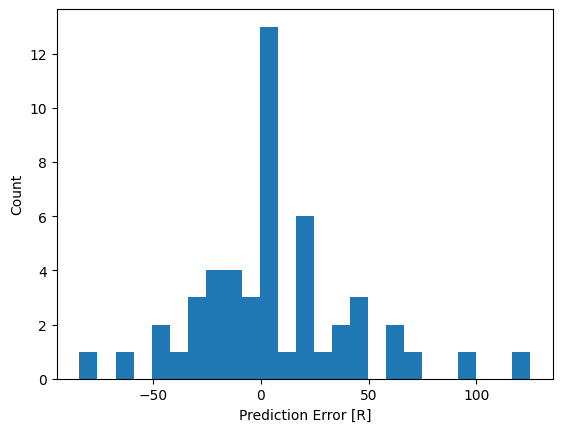

In [40]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
